# UMAP model

https://umap-learn.readthedocs.io/en/0.5dev/index.html

## Setup libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import seaborn as sns

In [4]:
from umap import UMAP

In [5]:
from sklearn.datasets import load_digits

In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [7]:
from sklearn.decomposition import PCA

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

In [10]:
from sklearn.model_selection import GridSearchCV

## Create utility functions

In [11]:
def cross_val_score_print(estimator, X_val, y_val):
    score = cross_val_score(
        estimator,
        X_val,
        y_val,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        error_score="raise",
    )
    print(
        "R2 {:.3f} +/- {:.3f}, count {}".format(
            np.mean(score), np.std(score), np.size(score)
        )
    )

In [12]:
def get_params_str(params):
    params_str = []
    key_prefix = "regressor"
    key_prefix_len = len(key_prefix)
    for key, value in params.items():
        trimmed_key = (
            key[key_prefix_len:] if key.startswith(key_prefix) else key
        )
        trimmed_key = (
            trimmed_key[2:] if trimmed_key.startswith("__") else trimmed_key
        )
        params_str.append(f"{trimmed_key}: {value}")
    return ", ".join(params_str)

In [13]:
def display_grid_cv_scores(grid):
    for idx, params in enumerate(grid.cv_results_["params"]):
        print(
            "{}: R2 {:.3f} +/- {:.3f}".format(
                get_params_str(params),
                grid.cv_results_["mean_test_score"][idx],
                grid.cv_results_["std_test_score"][idx],
            )
        )

## Get data

In [14]:
california_housing = fetch_california_housing(as_frame=True)

In [15]:
X_val = california_housing.data
y_val = california_housing.target

In [16]:
digits = load_digits()

## UMAP example

In [17]:
mapper = UMAP().fit_transform(digits.data)

<AxesSubplot:>

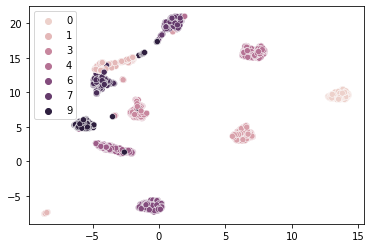

In [18]:
sns.scatterplot(x=mapper[:, 0], y=mapper[:, 1], hue=digits.target)

## Cross validation for one estimator

In [19]:
pipe = Pipeline([("scalar", StandardScaler()), ("dim_reducer", UMAP()), ("regressor", SVR())])
cross_val_score_print(pipe, X_val, y_val)

R2 0.360 +/- 0.089, count 3


## Cross validation for multiple estimators

In [20]:
steps = [
    ("scaler", StandardScaler()),
    ("dim_reducer", "passthrough"),
    ("regressor", "passthrough"),
]

In [21]:
pipe = Pipeline(steps)

In [22]:
regressors = [
    LinearRegression(),
    SVR(),
    LGBMRegressor(),
]

In [23]:
param_grid = [
    {
        "dim_reducer": [PCA(), UMAP()],
        "dim_reducer__n_components": [3, 6],
        "regressor": regressors,
    }
]
grid = GridSearchCV(pipe, cv=3, scoring="r2", n_jobs=-1, param_grid=param_grid)
grid.fit(X_val, y_val)
display_grid_cv_scores(grid)

dim_reducer: PCA(n_components=6), dim_reducer__n_components: 3, : LinearRegression(): R2 -0.058 +/- 0.094
dim_reducer: PCA(n_components=6), dim_reducer__n_components: 3, : SVR(): R2 0.147 +/- 0.148
dim_reducer: PCA(n_components=6), dim_reducer__n_components: 3, : LGBMRegressor(): R2 0.190 +/- 0.168
dim_reducer: PCA(n_components=6), dim_reducer__n_components: 6, : LinearRegression(): R2 0.458 +/- 0.029
dim_reducer: PCA(n_components=6), dim_reducer__n_components: 6, : SVR(): R2 0.574 +/- 0.060
dim_reducer: PCA(n_components=6), dim_reducer__n_components: 6, : LGBMRegressor(): R2 0.572 +/- 0.052
dim_reducer: UMAP(), dim_reducer__n_components: 3, : LinearRegression(): R2 0.062 +/- 0.171
dim_reducer: UMAP(), dim_reducer__n_components: 3, : SVR(): R2 0.446 +/- 0.024
dim_reducer: UMAP(), dim_reducer__n_components: 3, : LGBMRegressor(): R2 0.479 +/- 0.004
dim_reducer: UMAP(), dim_reducer__n_components: 6, : LinearRegression(): R2 0.390 +/- 0.009
dim_reducer: UMAP(), dim_reducer__n_components: 6